# Feature engineering

In this notebook I present the features I implemented to be extracted from the routing instances and be used as predictors in the distance estimation models.

## Contents in this notebook:
1. [Notebook setup](#setup)
2. [Features about service area](#area)
3. [Features about nodes (count, locations and distances)](#nodes)
4. [Features about demands and capacities](#demands)
5. [Features about service times and time windows](#times)

## 1. Notebook setup <a name="setup"></a>

In [1]:
# Install required packages.
# !pip install requirements.txt

# Change directory to main project folder.
import os
print(f'This folder: {os.getcwd()}')
os.chdir("..")
print(f'Project folder: {os.getcwd()}')

# Import packages.
import routing
import generation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm  
import seaborn as sns
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import time

This folder: C:\Users\muell\thesis_main\thesis_code\notebooks - GitHub
Project folder: C:\Users\muell\thesis_main\thesis_code


## 2. Features about service area <a name="area"></a>

### Area & Perimeter

Area: 4096.5
AreaRoot: 64.00390613079799
Perimeter: 266.31962795886


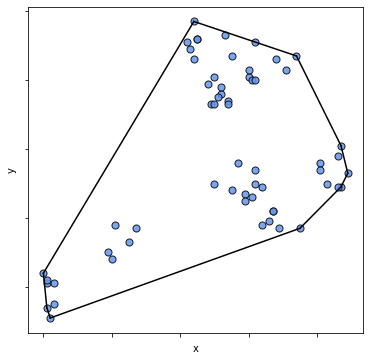

In [2]:
locations, depot_pos, loc_distr = generation.generate_locations(
    num_locations=60, depot_pos=None, loc_distr=None, lx=100, ly=100)
hull = ConvexHull(locations)
print('Area:', hull.volume)
print('AreaRoot:', np.sqrt(hull.volume))
print('Perimeter:', hull.area)


fig, ax = plt.subplots(1, figsize=(6,6))
ax.scatter(locations[:,0], locations[:,1], c='cornflowerblue', s = 50, alpha=0.85, ec='black')
for simplex in hull.simplices:
    ax.plot(locations[simplex, 0], locations[simplex, 1], 'k-')

ax.set(xlabel='x', ylabel='y')
ax.set_yticklabels([])
ax.set_xticklabels([])
#plt.savefig('areafeature1.eps', format='eps', pad_inches=0.4)#bbox_inches='tight')
#plt.savefig('areafeature1.jpg', pad_inches=0.4, dpi=300)#bbox_inches='tight')
plt.show()

### Side lengths & ratio

MajorSide: 102.2584986716752
MinorSide: 61.60616986289199
SideRatio: 1.6598743096553035


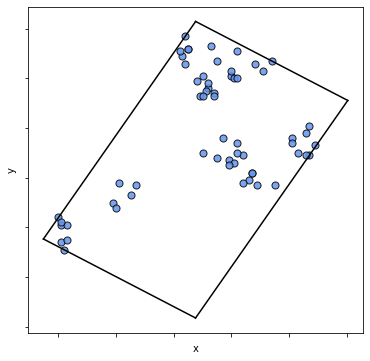

In [3]:
# side lengths and ratio for instance locations

bounding_box = generation.MinimumBoundingBox(locations)  # returns namedtuple
minor = min(bounding_box.length_parallel, bounding_box.length_orthogonal)
major = max(bounding_box.length_parallel, bounding_box.length_orthogonal)
corners = np.array([list(b) for b in bounding_box.corner_points])
print('MajorSide:', major)
print('MinorSide:', minor)
print('SideRatio:', major/minor)

fig, ax = plt.subplots(1, figsize=(6,6))
# plt.axis('equal')
ax.scatter(locations[:,0], locations[:,1], c='cornflowerblue', s = 50, alpha=0.85, ec='black')
ax.plot(corners[[0,1],0], corners[[0,1],1], 'k-')
ax.plot(corners[[0,2],0], corners[[0,2],1], 'k-')
#ax.plot(corners[[0,3],0], corners[[0,3],1], 'k-')
#ax.plot(corners[[1,2],0], corners[[1,2],1], 'k-')
ax.plot(corners[[1,3],0], corners[[1,3],1], 'k-')
ax.plot(corners[[2,3],0], corners[[2,3],1], 'k-')
ax.set(xlabel='x', ylabel='y')
ax.set_yticklabels([])
ax.set_xticklabels([])
#plt.savefig('areafeature2.eps', format='eps', pad_inches=0.4)#bbox_inches='tight')
#plt.savefig('areafeature2.jpg', pad_inches=0.4, dpi=300)#bbox_inches='tight')
plt.show()

## 3. Features about nodes (count, locations and distances) <a name="nodes"></a>

### Number of customers

In [4]:
# Number of customers

locations, depot_pos, loc_distr = generation.generate_locations(
    num_locations=100, depot_pos=None, loc_distr=None, lx=100, ly=100)
print('NumCust:', locations.shape[0] - 1)

NumCust: 99


### Centrality & Dispersion

In [17]:
instance = generation.generate_instance(num_customers=7)

from scipy.spatial import distance

avg_node = np.array([np.mean(instance.locations[:,0]), np.mean(instance.locations[:,1])])
cent_dist = distance.cdist(instance.locations, np.reshape(avg_node, (-1, 2)), 'euclidean')
cent_dist = cent_dist.flatten()
print('CentDepot:', cent_dist[0])
print('CentCustAvg:', np.mean(cent_dist[1:]))
print('CentCustStd:', np.std(cent_dist[1:]))

print('Dispersion:', np.std(instance.locations[:,0]) * np.std(instance.locations[:,1]))
# from other studies
print('AvgFurthest:', np.mean(np.max(instance.distance_matrix, axis=0)))
print('AvgNearest:', np.mean(np.partition(instance.distance_matrix, 1, axis=1)[:,1]))

CentDepot: 339.285017449736
CentCustAvg: 182.7330536458928
CentCustStd: 92.21992725663391
Dispersion: 20506.61852124614
AvgFurthest: 503.71625
AvgNearest: 133.65375


### Depot-customer distances

In [18]:
i = generation.generate_instance(num_customers=7)
depot_cust  = i.distance_matrix[0,1:]
print('DepCustAvg:', np.mean(depot_cust))
print('DepCustStd:', np.std(depot_cust))
print('DepCustMin:', np.min(depot_cust))
print('DepCustMed:', np.median(depot_cust))
print('DepCustMax:', np.max(depot_cust))

DepCustAvg: 72.29285714285714
DepCustStd: 38.123195306901586
DepCustMin: 5.62
DepCustMed: 79.8
DepCustMax: 117.2


### Inter-customer distances

In [19]:
# Consider only those connections for which the following condition holds:
# STW_i + serv_i + d_ij <= ETW_j

[[  0. 142. 231. 274. 165. 181. 155. 353.]
 [142.   0.  92. 134. 203. 240. 295. 353.]
 [231.  92.   0.  43. 284. 288. 379. 352.]
 [274. 134.  43.   0. 319. 323. 422. 370.]
 [165. 203. 284. 319.   0. 345. 264. 511.]
 [181. 240. 288. 323. 345.   0. 195. 188.]
 [155. 295. 379. 422. 264. 195.   0. 380.]
 [353. 353. 352. 370. 511. 188. 380.   0.]]
[   0. 1881. 3740. 1041. 6601. 5247. 3128. 3623.]
[  0 831 831 831 831 831 831 831]
[10128.  1918.  4848.  1892.  7122.  5615.  8257.  6940.]


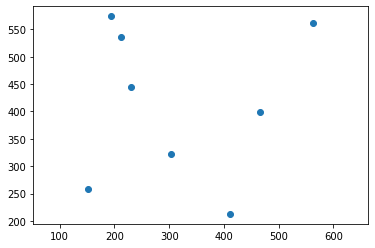

In [20]:
# generate an instance

i = generation.generate_instance(num_customers=7)
print(np.around(i.distance_matrix, 0))
print(np.around(i.time_windows[:,0], 0))
print(np.around(i.service_times, 0))
print(np.around(i.time_windows[:,1], 0))

plt.plot(i.locations[:,0], i.locations[:,1], 'o')
plt.axis('equal')
plt.show()

In [21]:
# create boolean mask which inter cust links are possible
# Values are negative if the condition holds

dm = i.distance_matrix.copy()
dm += np.vstack(i.service_times)
dm += np.vstack(i.time_windows[:,0])
dm -= i.time_windows[:,1]
mask = dm <= 0
print(np.around(dm, 0))
print(mask)

[[-10128.  -1776.  -4617.  -1618.  -6958.  -5434.  -8102.  -6587.]
 [ -7274.    794.  -2044.    954.  -4207.  -2662.  -5250.  -3875.]
 [ -5326.   2744.   -277.   2721.  -2268.   -756.  -3307.  -2017.]
 [ -7982.     88.  -2933.    -20.  -4931.  -3419.  -5963.  -4698.]
 [ -2532.   5716.   2868.   5859.    309.   2163.   -561.   1004.]
 [ -3870.   4400.   1518.   4509.   -699.    463.  -1985.   -674.]
 [ -6014.   2336.   -509.   2489.  -2899.  -1460.  -4298.  -2601.]
 [ -5321.   2888.    -42.   2931.  -2157.   -973.  -3424.  -2486.]]
[[ True  True  True  True  True  True  True  True]
 [ True False  True False  True  True  True  True]
 [ True False  True False  True  True  True  True]
 [ True False  True  True  True  True  True  True]
 [ True False False False False False  True False]
 [ True False False False  True False  True  True]
 [ True False  True False  True  True  True  True]
 [ True False  True False  True  True  True  True]]


In [22]:
# delete depot connections as those are captured in a separate feature

inter_cust = np.delete(i.distance_matrix, [0], 0)
inter_cust = np.delete(inter_cust, [0], 1)
mask = np.delete(mask, [0], 0)
mask = np.delete(mask, [0], 1)
print(np.around(inter_cust, 0))
print(np.around(mask, 0))

[[  0.  92. 134. 203. 240. 295. 353.]
 [ 92.   0.  43. 284. 288. 379. 352.]
 [134.  43.   0. 319. 323. 422. 370.]
 [203. 284. 319.   0. 345. 264. 511.]
 [240. 288. 323. 345.   0. 195. 188.]
 [295. 379. 422. 264. 195.   0. 380.]
 [353. 352. 370. 511. 188. 380.   0.]]
[[0. 1. 0. 1. 1. 1. 1.]
 [0. 1. 0. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1. 1.]
 [0. 1. 0. 1. 1. 1. 1.]
 [0. 1. 0. 1. 1. 1. 1.]]


In [23]:
# delete diagonal (connections between nodes with themselves)

inter_cust = inter_cust[~np.eye(inter_cust.shape[0],dtype=bool)].reshape(inter_cust.shape[0],-1)
mask = mask[~np.eye(mask.shape[0],dtype=bool)].reshape(mask.shape[0],-1)
print(np.around(inter_cust, 0))
print(np.around(mask, 0))

[[ 92. 134. 203. 240. 295. 353.]
 [ 92.  43. 284. 288. 379. 352.]
 [134.  43. 319. 323. 422. 370.]
 [203. 284. 319. 345. 264. 511.]
 [240. 288. 323. 345. 195. 188.]
 [295. 379. 422. 264. 195. 380.]
 [353. 352. 370. 511. 188. 380.]]
[[1. 0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1. 1.]
 [0. 1. 0. 1. 1. 1.]
 [0. 1. 0. 1. 1. 1.]]


In [24]:
# make 1d array

inter_cust = inter_cust.ravel()
mask = mask.ravel()
print(np.around(inter_cust, 0))
print(np.around(mask, 0))

[ 92. 134. 203. 240. 295. 353.  92.  43. 284. 288. 379. 352. 134.  43.
 319. 323. 422. 370. 203. 284. 319. 345. 264. 511. 240. 288. 323. 345.
 195. 188. 295. 379. 422. 264. 195. 380. 353. 352. 370. 511. 188. 380.]
[1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1.]


In [25]:
# apply boolean mask to get possible links

inter_cust = inter_cust[np.where(mask)]
print(np.around(inter_cust, 1))

[ 92.1 202.9 240.5 294.8 352.8 283.9 288.2 379.4 352.2  42.8 318.9 323.4
 421.9 369.7 264.3 345.4 194.8 188.1 379.4 264.3 194.8 379.8 352.2 511.4
 188.1 379.8]


In [26]:
# summarize all steps

# delete depot connections from distance matrix
inter_cust = np.delete(i.distance_matrix, [0], 0)
inter_cust = np.delete(inter_cust, [0], 1)
# create boolean mask which inter cust links are possible
condition = (((
    inter_cust 
    + np.vstack(i.time_windows[1:,0])) 
    + np.vstack(i.service_times[1:])) 
    - i.time_windows[1:,1]
) <= 0
# delete diagonal and make 1d array
inter_cust = inter_cust[~np.eye(inter_cust.shape[0],dtype=bool)].reshape(inter_cust.shape[0],-1).ravel()
condition = condition[~np.eye(condition.shape[0],dtype=bool)].reshape(condition.shape[0],-1).ravel()
# make 1d array and apply boolean mask
inter_cust = inter_cust[np.where(condition)]
print('IntCust:', np.around(inter_cust, 1))
total_links = (i.distance_matrix.shape[0] - 1) * (i.distance_matrix.shape[1] - 2)
possible_links = inter_cust.shape[0]
print('IntCustLinks:', possible_links / total_links)
print('IntCustAvg:', np.mean(inter_cust))
print('IntCustStd:', np.std(inter_cust))
print('IntCustMin:', np.min(inter_cust))
print('IntCustMed:', np.median(inter_cust))
print('IntCustMax:', np.max(inter_cust))

IntCust: [ 92.1 202.9 240.5 294.8 352.8 283.9 288.2 379.4 352.2  42.8 318.9 323.4
 421.9 369.7 264.3 345.4 194.8 188.1 379.4 264.3 194.8 379.8 352.2 511.4
 188.1 379.8]
IntCustLinks: 0.6190476190476191
IntCustAvg: 292.54923076923075
IntCustStd: 102.28268222931811
IntCustMin: 42.75
IntCustMed: 306.855
IntCustMax: 511.41


## 4. Features about demands and capacities <a name="demands"></a>

In [27]:
# demand coverage
print('CapRatio =', instance.vehicle_capacities[0] / np.sum(instance.demands[1:]))
print('NumVehMin =', np.sum(instance.demands[1:]) / instance.vehicle_capacities[0])

CapRatio = 0.5470297029702971
NumVehMin = 1.8280542986425339


In [28]:
# demand characteristics
relative_demands = instance.demands[1:] / instance.vehicle_capacities[0]
print('DemAvg:', np.mean(relative_demands))
print('DemStd:', np.std(relative_demands))
print('DemMin:', np.min(relative_demands))
print('DemMed:', np.median(relative_demands))
print('DemMax:', np.max(relative_demands))

DemAvg: 0.2611506140917906
DemStd: 0.12627398006024337
DemMin: 0.09502262443438914
DemMed: 0.2171945701357466
DemMax: 0.4298642533936652


## 5. Features about service times and time windows <a name="times"></a>

In [29]:
# time horizon
TwDepot = instance.time_windows[0,1]
print('PossRounds =', TwDepot / ConvexHull(instance.locations).area)

PossRounds = 4.07325410998708


In [33]:
# service time characteristics
relative_service_times = instance.service_times[1:] / TwDepot
print('StAvg:', np.mean(relative_service_times))
print('StStd:', np.std(relative_service_times))
print('StMin:', np.min(relative_service_times))
print('StMed:', np.median(relative_service_times))
print('StMax:', np.max(relative_service_times))

StAvg: 0.005680618077547652
StStd: 0.00276617214173049
StMin: 0.0020351820671528987
StMed: 0.004696574001122074
StMax: 0.009393148002244148


In [34]:
# share with time windows
rel_time_windows = instance.time_windows / TwDepot
rel_tw_constrained = np.array([tw for tw in rel_time_windows if (tw!=rel_time_windows[0]).any()])
print('TwShare:', rel_tw_constrained.shape[0] / (instance.locations.shape[0] -1))

TwShare: 0.8571428571428571


In [35]:
# time windows widths
rel_tw_widths = rel_time_windows[1:,1] - rel_time_windows[1:,0]
print('TwWidthAvg:', np.mean(rel_tw_widths))
print('TwWidthStd:', np.std(rel_tw_widths))
print('TwWidthMin:', np.min(rel_tw_widths))
print('TwWidthMed:', np.median(rel_tw_widths))
print('TwWidthMax:', np.max(rel_tw_widths))

TwWidthAvg: 0.3417540437608381
TwWidthStd: 0.3132992352805368
TwWidthMin: 0.002147164046586214
TwWidthMed: 0.2577106121077772
TwWidthMax: 1.0


In [36]:
# time windows centers
rel_tw_centers = (rel_time_windows[1:,0] + rel_time_windows[1:,1]) / 2
print('TwWCentAvg:', np.mean(rel_tw_centers))
print('TwCentStd:', np.std(rel_tw_centers))
print('TwCentMin:', np.min(rel_tw_centers))
print('TwCentMed:', np.median(rel_tw_centers))
print('TwCentMax:', np.max(rel_tw_centers))

TwWCentAvg: 0.5492583513634622
TwCentStd: 0.2516059976392652
TwCentMin: 0.17785641599522226
TwCentMed: 0.5
TwCentMax: 0.8554809308215159


## Inspect for an example instance

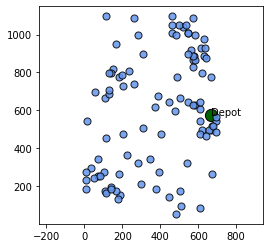

In [37]:
i1 = generation.generate_instance()
#print(i1.__dict__)
i1.plot(scaled=True)

In [38]:
features = generation.extract_features_instance(i1)
features

{'NumCust': 99.0,
 'AreaRoot': 781.3516901729273,
 'Perimeter': 3023.522864220081,
 'SideRatio': 1.5144354035174008,
 'CentDepot': 0.35335681794865365,
 'CentCustAvg': 0.4500471018955645,
 'CentCustStd': 0.15758043326467192,
 'Dispersion': 0.32807118096540255,
 'AvgFurthest': 1.12648863638498,
 'AvgNearest': 0.05619108597600017,
 'DepCustAvg': 0.5370999316595324,
 'DepCustStd': 0.25745055320723753,
 'DepCustMin': 0.040045987477258745,
 'DepCustMed': 0.6034542523298904,
 'DepCustMax': 0.9777415338167654,
 'IntCustLinks': 0.5661719233147805,
 'IntCustAvg': 0.5901565315409679,
 'IntCustStd': 0.30198625307042004,
 'IntCustMin': 0.0,
 'IntCustMed': 0.5830409094004472,
 'IntCustMax': 1.4118994223405905,
 'CapRatio': 0.24860601115191078,
 'NumVehMin': 4.022428884026258,
 'DemAvg': 0.04063059478814402,
 'DemStd': 0.007578024352339281,
 'DemMin': 0.02735229759299781,
 'DemMed': 0.04157549234135667,
 'DemMax': 0.05415754923413567,
 'PossRounds': 2.9102321018067596,
 'StAvg': 0.000909178386515894